# POP MOC(sig2) for 1-degree
 - Computes MOC(sig2) offline from POP history files using simple xhistogram binning

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
from xhistogram.xarray import histogram
import pop_tools
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc

In [2]:
dask.__version__

'2021.09.0'

### Start Dask Cluster

In [ ]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(15) 

In [4]:
cluster

### 1. Read in OGCM history file & MOC template file

In [34]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    #ds_out = ds.copy(deep)
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

def preprocessor(ds0):
    d0 = time_set_midmonth(ds0,'time')
    #d0 = d0.groupby('time.year').mean('time').rename({'year':'time'})
    return d0

In [35]:
# Read in 10 years of monthly SMYLE-FOSI POP output:
fdir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/hist/'
fin = fdir + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.035?-??.nc'
ds = xr.open_mfdataset(fin,combine='by_coords',
                       preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,)

In [36]:
## MOC Grid information
fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

### 2. Compute sigma-2 field from POP model output

In [37]:
# Get model T & S
salt = ds['SALT']
temp = ds['TEMP']

In [38]:
%%time
refz = 2000
refdep = xr.full_like(ds['z_t'],refz).rename('REFDEP')

# Sigma2 on model TLAT, TLONG
sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})

## Following may be needed for some CESM2 LENS output (simulations run in Korea):
#dims = np.shape(temp)
#nt = dims[0]
#nz = dims[1]
#ny = dims[2]
#nx = dims[3]
#kji = np.indices((nz,ny,nx))
#kindices = kji[0,:,:,:] + 1
# apply T-grid mask
#mask=kindices<=ds['KMT'].values[None,:,:]
#sigma2_T = sigma2_T.where(mask)

CPU times: user 3.54 s, sys: 729 ms, total: 4.27 s
Wall time: 4.36 s


### 3. Define target sigma-2 vertical grid
- Use a predefined target grid, or create your own!

In [39]:
# Use predefined 86-layer sigma2 grid:
sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()

In [40]:
sigma_mid

<xarray.DataArray (sigma: 86)>
array([28.  , 28.2 , 28.4 , 28.6 , 28.8 , 29.  , 29.2 , 29.4 , 29.6 ,
       29.8 , 30.  , 30.2 , 30.4 , 30.6 , 30.8 , 31.  , 31.2 , 31.4 ,
       31.6 , 31.8 , 32.  , 32.2 , 32.4 , 32.6 , 32.8 , 33.  , 33.2 ,
       33.4 , 33.6 , 33.8 , 34.  , 34.2 , 34.4 , 34.6 , 34.8 , 35.  ,
       35.1 , 35.2 , 35.3 , 35.4 , 35.5 , 35.6 , 35.7 , 35.8 , 35.9 ,
       36.  , 36.05, 36.1 , 36.15, 36.2 , 36.25, 36.3 , 36.35, 36.4 ,
       36.45, 36.5 , 36.55, 36.6 , 36.65, 36.7 , 36.75, 36.8 , 36.85,
       36.9 , 36.95, 37.  , 37.05, 37.1 , 37.15, 37.2 , 37.25, 37.3 ,
       37.35, 37.4 , 37.45, 37.5 , 37.55, 37.6 , 37.65, 37.7 , 37.75,
       37.8 , 37.85, 37.9 , 37.95, 38.  ])
Coordinates:
  * sigma    (sigma) float64 28.0 28.2 28.4 28.6 28.8 ... 37.85 37.9 37.95 38.0
Attributes:
    long_name:  Sigma2 at middle of layer
    units:      kg/m^3

In [41]:
sigma_edge

<xarray.DataArray (sigma: 87)>
array([ 0.   , 28.1  , 28.3  , 28.5  , 28.7  , 28.9  , 29.1  , 29.3  ,
       29.5  , 29.7  , 29.9  , 30.1  , 30.3  , 30.5  , 30.7  , 30.9  ,
       31.1  , 31.3  , 31.5  , 31.7  , 31.9  , 32.1  , 32.3  , 32.5  ,
       32.7  , 32.9  , 33.1  , 33.3  , 33.5  , 33.7  , 33.9  , 34.1  ,
       34.3  , 34.5  , 34.7  , 34.9  , 35.05 , 35.15 , 35.25 , 35.35 ,
       35.45 , 35.55 , 35.65 , 35.75 , 35.85 , 35.95 , 36.025, 36.075,
       36.125, 36.175, 36.225, 36.275, 36.325, 36.375, 36.425, 36.475,
       36.525, 36.575, 36.625, 36.675, 36.725, 36.775, 36.825, 36.875,
       36.925, 36.975, 37.025, 37.075, 37.125, 37.175, 37.225, 37.275,
       37.325, 37.375, 37.425, 37.475, 37.525, 37.575, 37.625, 37.675,
       37.725, 37.775, 37.825, 37.875, 37.925, 37.975, 50.   ])
Coordinates:
  * sigma    (sigma) float64 0.0 28.1 28.3 28.5 28.7 ... 37.87 37.92 37.97 50.0
Attributes:
    long_name:  Sigma2 at edges of layer
    units:      kg/m^3

### 4. Compute Isopycnal Layer Thickness

In [42]:
# Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

kmtdiff = iso_count.sum('sigma') - ds['KMT']
print("Max difference from true KMT = {}".format(abs(kmtdiff).max().values))

Max difference from true KMT = 0.0


In [43]:
# Use histogram to compute layer thickness. Vertical sum should be same as HT.
dzwgts = (ds['dz']/100.).assign_attrs({'units':'m'})
iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzwgts,dim=['z_t'],density=False)
iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_thick = iso_thick.rename('iso_thick').assign_attrs({'units':'m','long_name':'Isopycnal Layer Thickness'}).rename({'sigma':'sigma_mid'})
iso_thick = iso_thick.transpose('time','sigma_mid','nlat','nlon')

htdiff = iso_thick.sum('sigma_mid') - (ds['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 0.0008469375015920377m


### 5. Compute Isopycnal Layer Depth

In [44]:
# Cumulative sum of layer thickness yields depth of layer edges:
iso_depth = iso_thick.cumsum('sigma_mid').rename('iso_depth').rename({'sigma_mid':'sigma_bot'}).assign_attrs({'units':'m','long_name':'Isopycnal Layer Depth'})
sigma_bot = sigma_edge.isel(sigma=slice(1,None)).rename({'sigma':'sigma_bot'}).assign_attrs({'long_name':'Sigma2 at bottom of layer'})
iso_depth['sigma_bot'] = sigma_bot
iso_depth = iso_depth.transpose('time','sigma_bot','nlat','nlon')

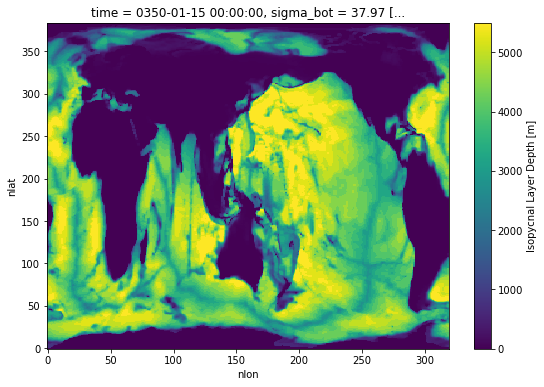

In [46]:
iso_depth.isel(time=0,sigma_bot=84).plot(size=6,vmax=5500)

In [47]:
# Isopycnal depth of bottom-most layer should be same as HT.
htdiff =  iso_depth.isel(sigma_bot=-1) - (ds['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 0.0006182187498779967m


### 6. Compute Isopycnal Layer Horizontal Volume Flux

In [48]:
## Grid Metrics
dxu = ds['DXU']
dyu = ds['DYU']
dxt = ds['DXT']
dyt = ds['DYT']
dz = ds['dz']
tarea = ds['TAREA']

In [49]:
u_e = ds['UVEL']
u_e = u_e.where(u_e<1.e30,0)
u_i = ds['UISOP'].drop(['TLONG','ULAT'])
u_i = u_i.where(u_i<1.e30,0)
u_s = ds['USUBM'].drop(['TLONG','ULAT'])
u_s = u_s.where(u_s<1.e30,0)
v_e = ds['VVEL']
v_e = v_e.where(v_e<1.e30,0)
v_i = ds['VISOP'].drop(['ULONG','TLAT'])
v_i = v_i.where(v_i<1.e30,0)
v_s = ds['VSUBM'].drop(['ULONG','TLAT'])
v_s = v_s.where(v_s<1.e30,0)

In [50]:
%%time
# Grid-oriented Volume FLuxes:
u_e = (u_e*dyu*dz/1.e6).assign_attrs({'units':'m^3/s'})
v_e = (v_e*dxu*dz/1.e6).assign_attrs({'units':'m^3/s'})
u_i = (u_i*dyt*dz/1.e6).assign_attrs({'units':'m^3/s'})
v_i = (v_i*dxt*dz/1.e6).assign_attrs({'units':'m^3/s'})
u_s = (u_s*dyt*dz/1.e6).assign_attrs({'units':'m^3/s'})
v_s = (v_s*dxt*dz/1.e6).assign_attrs({'units':'m^3/s'})

CPU times: user 30.8 ms, sys: 933 µs, total: 31.8 ms
Wall time: 32.1 ms


In [51]:
# Convert u_e,v_e to C-grid fluxes
u_e = 0.5*(u_e+u_e.shift(nlat=1))
v_e = 0.5*(v_e+v_e.roll(nlon=1,roll_coords=False))

In [52]:
# Combine velocity components 
u = xr.concat([u_e,u_i,u_s],dim=ds_moctemp.moc_components)
v = xr.concat([v_e,v_i,v_s],dim=ds_moctemp.moc_components)

In [53]:
%%time
# Volume fluxes in density-space. 
iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

# Look for fix to histogram keep_coords=True to avoid this step in future:
iso_uflux = iso_uflux.assign_coords({'moc_components':ds_moctemp.moc_components})
iso_vflux = iso_vflux.assign_coords({'moc_components':ds_moctemp.moc_components})

CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 26.5 ms


In [58]:
%%time
# Vertical sum in density-space should reproduce vertical sum in depth-space
ufluxdiff = iso_uflux.isel(time=0).sum('sigma') - u.isel(time=0).sum('z_t')
print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
vfluxdiff = iso_vflux.isel(time=0).sum('sigma') - v.isel(time=0).sum('z_t')
print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))

Max difference from true Uflux = 1594036.864045458
Max difference from true Vflux = 220178.16448075892
CPU times: user 577 ms, sys: 23.9 ms, total: 601 ms
Wall time: 3.54 s


The above large differences appear to be associated with the Nordic Sea overflow parameterization. I'm not sure how to handle overflow velocities in the MOC computation:

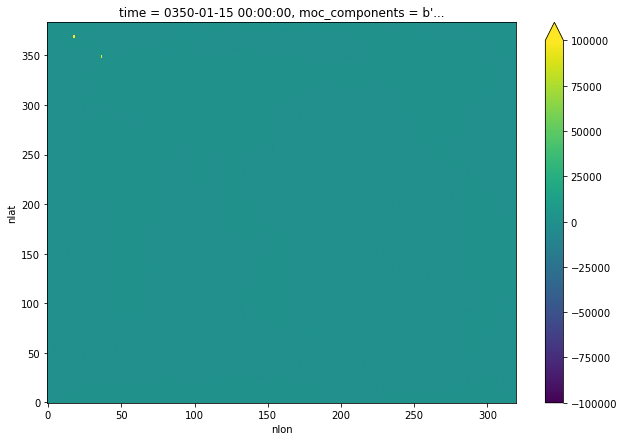

In [59]:
ufluxdiff.isel(moc_comp=0).plot(size=7,vmin=-1.e5,vmax=1.e5)

### 7. Compute Vertical Volume Flux from horizontal flux convergence

In [60]:
%%time
wflux = popmoc.wflux(iso_uflux,iso_vflux,'sigma',sigma_edge,grid='C')
wflux = wflux.assign_coords({'TLAT':ds['TLAT'],'TLONG':ds['TLONG']}).drop(['ULAT','ULONG'])

CPU times: user 46 ms, sys: 1.96 ms, total: 48 ms
Wall time: 48.3 ms


### 8. Define MOC region masks

In [61]:
## Define the MOC region mask:
rmask = ds.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

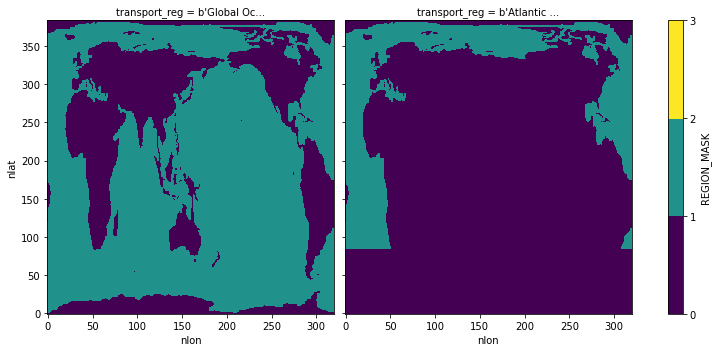

In [62]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

### 9. Compute MOC

In [67]:
%%time
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
MOC = MOC.transpose('time','transport_reg','moc_comp','sigma','lat_aux_grid')

CPU times: user 52.3 ms, sys: 3.86 ms, total: 56.2 ms
Wall time: 57.6 ms


In [68]:
%%time
# Main computation here:
MOC = MOC.load()

CPU times: user 38.3 s, sys: 1.43 s, total: 39.7 s
Wall time: 2min 13s


### 10. Add Southern Boundary Fluxes for Atlantic Region

In [69]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

84

In [70]:
%%time
# add vflux at southern boundary of Atlantic domain
tmp = iso_vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon')
moc_s = -tmp.sortby('sigma',ascending=False).cumsum('sigma').sortby('sigma',ascending=True)/1.e6
moc_s['sigma'] = sigma_edge.isel(sigma=slice(0,-1))
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + moc_s

CPU times: user 15 s, sys: 678 ms, total: 15.7 s
Wall time: 58.9 s


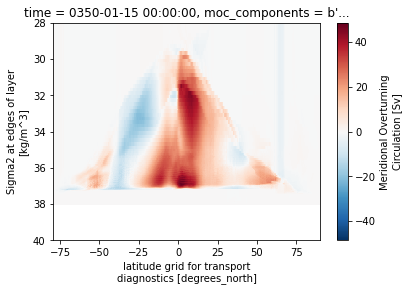

In [71]:
MOC.isel(time=0).isel(transport_reg=0,moc_comp=0).plot(ylim=[40,28])

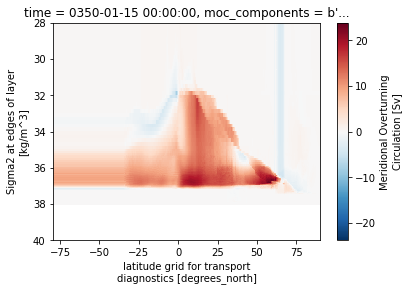

In [72]:
MOC.isel(time=0).isel(transport_reg=1,moc_comp=0).plot(ylim=[40,28])

### 11. Save to netcdf

In [73]:
MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})
dsout = MOCann.to_dataset()

In [74]:
dsout

<xarray.Dataset>
Dimensions:         (lat_aux_grid: 395, sigma: 86, moc_comp: 3,
                     transport_reg: 2, time: 10)
Coordinates:
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * sigma           (sigma) float64 0.0 28.1 28.3 28.5 ... 37.87 37.92 37.97
    moc_components  (moc_comp) |S256 b'Eulerian Mean' ... b'Submeso'
  * transport_reg   (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'A...
  * time            (time) int64 350 351 352 353 354 355 356 357 358 359
Dimensions without coordinates: moc_comp
Data variables:
    MOC             (time, transport_reg, moc_comp, sigma, lat_aux_grid) float64 ...

In [75]:
fout = '/glade/scratch/yeager/POP_MOC/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.0350-0359.MOCsig2.nc'
dsout.to_netcdf(fout,unlimited_dims='time')